An example of interpolation (Integrated with other notebooks)
----

In [1]:
# !pip install -e Assimilation

%load_ext autoreload
%autoreload 2

In [2]:
# import sys
# import os
# sys.path.insert(0, os.path.abspath('/home/jovyan/Assimilation/simlib'))
from simlib.coregistration import reference_dem
from simlib import atl06lib
import glob
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import dask.dataframe as dd

%matplotlib inline
# %matplotlib widget

1. Download Baker DEM file

See contributors/friedrichknuth/download_reference_dem.ipynb for more details

In [3]:
# # Comment this cell for downloading Baker DEM

# %%capture
# current_directory = !pwd
# current_directory = current_directory[0]
# %cd ~/
# ! git clone https://github.com/friedrichknuth/driveanon.git
# ! pip install ./driveanon
# %cd {current_directory}
# import driveanon
# blob_id = '1-8Ca-9_HJL4S7CrX4x5hzH-nrjD4Thpq'
# %mkdir ~/data
# %cd ~/data
# driveanon.save(blob_id)
# %cd {current_directory}
# ! gdalinfo ~/data/reference_dem_clip.tif

2. Load the Baker DEM file as reference_dem class, get bounding box for downloading ICESat-2 data

In [4]:
dem_path = '/home/jovyan/data/reference_dem_clip.tif'
dem = reference_dem(dem_path)
dem.calculate_bounding_box('4326')
bbox = dem.bbox
print(bbox)
print(dem.epsg)

# dem.calculate_bounding_box('32610')
# print(bbox)

# Baken DEM EPSG: 32610

[-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505]
32610


3. Download ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [5]:
# # Comment this cell for downloading ICESat-2 data

# from icepyx import icesat2data as ipd

# # query datasets
# short_name = 'ATL06'
# date_range = ['2018-10-14','2020-04-04']
# bbox = [-121.87893182746436, 48.70258466806347, -121.79542720391288, 48.7704252035505] #[lonmin,latmin,lonmax,latmax]

# # Earthdata Login user name and associated email
# earthdata_uid = 'jhsttshj'
# email = 'wz278@cornell.edu'

# region = ipd.Icesat2Data(short_name, bbox, date_range)
# region.earthdata_login(earthdata_uid, email)
# region.download_granules('/home/jovyan/data/ICESat-2_Baker')

4. Load ICESat-2 data

See contributors/icetianli/READ_ATL06.ipynb for more datil

In [6]:
# files = glob.glob('/home/jovyan/data/ICESat-2_Baker/*.h5')
# outdir = '/home/jovyan/data/ICESat-2_Baker_Processed'
# # print(files)

# for f in files:
#     atl06lib.read_atl06(f, dem.epsg, outdir, bbox)

# !du -hs /home/jovyan/data/ICESat-2_Baker_Processed/*.h5

In [7]:
files = glob.glob('/home/jovyan/data/ICESat-2_Baker_Processed/*.h5')
# files = glob.glob('/home/jovyan/data/ATL06_Processed/*.h5')
# print(files)

# Variables we want to plot
vnames = ['x', 'y', 'h_li']

# List with one dataframe per file
dfs = [dd.from_array(atl06lib.read_h5(f, vnames)[0], columns=vnames) for f in files]

# Single parallel dataframe (larger than memory)
df = dd.concat(dfs)

print('Number of files:', len(files))
print('Number of points:', len(df))
#print(df.head())

# dask dataframe convert to pandas dataframe
ddf = df.compute()

Number of files: 17
Number of points: 894


5. Plot

(from Shean's tutorials and Tian's code)

In [8]:
# ddf_gpd = gpd.GeoDataFrame(glas_df, geometry=gpd.points_from_xy(glas_df['lon'], glas_df['lat']), crs='EPSG:32610')
ddf_gpd = gpd.GeoDataFrame(ddf, geometry=gpd.points_from_xy(ddf['x'], ddf['y']), crs='EPSG:32610')
ddf_gpd

,x,y,h_li,geometry
0,585820.033780,5.402471e+06,2641.562988,POINT (585820.034 5402470.987)
1,585818.482160,5.402451e+06,2635.364014,POINT (585818.482 5402451.019)
2,585812.354739,5.402371e+06,2603.774902,POINT (585812.355 5402371.143)
3,585810.797554,5.402351e+06,2601.487793,POINT (585810.798 5402351.175)
4,585809.211173,5.402331e+06,2599.798340,POINT (585809.211 5402331.202)
...,...,...,...,...
3,588459.384185,5.395325e+06,1190.703979,POINT (588459.384 5395325.108)
4,588457.824303,5.395305e+06,1184.791992,POINT (588457.824 5395305.140)
5,588454.681982,5.395265e+06,1176.595703,POINT (588454.682 5395265.205)
6,588453.107356,5.395245e+06,1172.540527,POINT (588453.107 5395245.238)


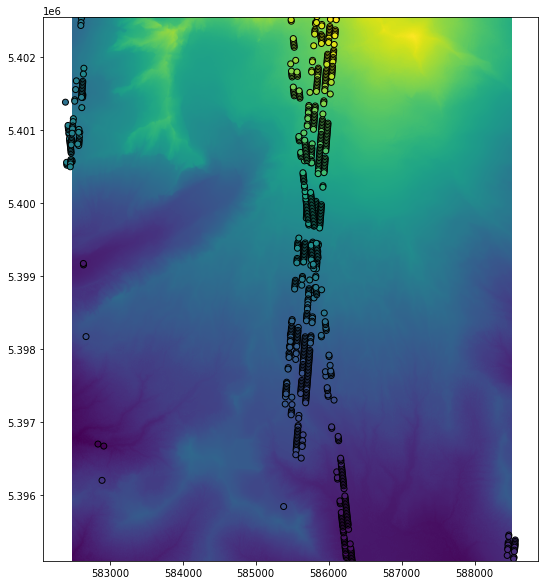

In [9]:
fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
ddf_gpd.plot(ax=ax, column='h_li', edgecolor='black')

6. Calculating difference

Partly from Fredrick's code

In [10]:
import rasterio
import rasterio.sample as rio_sample

rio_ds = rasterio.open(dem_path)
ddf_xytuple = list(ddf_gpd[['x', 'y']].to_records(index=False))
# print(ddf_xytuple)
sample_gen = rio_ds.sample(ddf_xytuple)
rasterddf_gpd = gpd.GeoDataFrame()

h_raster = [float(record) for record in sample_gen]
# print(h_raster)
ddf_gpd['h_raster'] = h_raster
ddf_gpd['li_raster'] = ddf_gpd['h_li'] - ddf_gpd['h_raster']



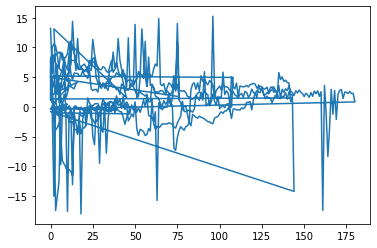

In [11]:
tmp = ddf_gpd[ddf_gpd['li_raster'] < 20]
ddf_gpd_cleaned = tmp[tmp['li_raster'] > -20]

plt.plot(ddf_gpd_cleaned['li_raster'])


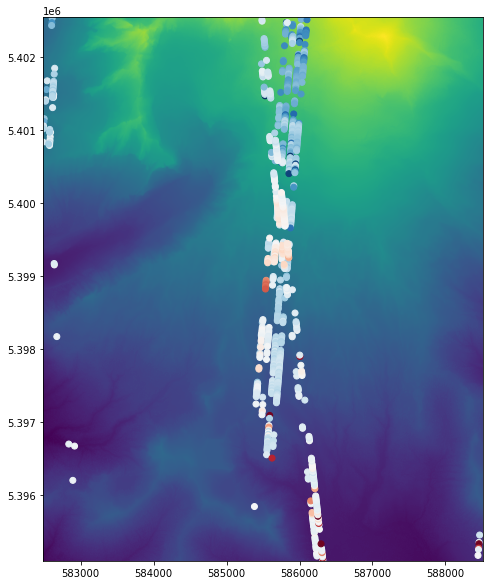

In [12]:

fig,ax = plt.subplots(1,figsize=(10,10))
dem.show(ax=ax)
ddf_gpd_cleaned.plot(ax=ax, column='li_raster', cmap='RdBu', clim=[-20, 20])

7. interpolating ICESat-2

In [13]:
# Now we are using the captoolkit - Cryosphere Altimetry Processing Toolkit 

# git clone https://github.com/fspaolo/captoolkit.git
# cd captoolkit
# python setup.py install

# well, for now I just use the utils.py Johan Nilsson provided at the tutorial session!
from utils import interpkrig, interpmed, interpgaus
from scipy import interpolate

In [14]:
ddf_xy_cleaned = list(zip(ddf_gpd_cleaned['x'], ddf_gpd_cleaned['y']))
grid_x, grid_y = np.meshgrid(dem.x, dem.y)
grid_x_s = grid_x[::100, ::100]
grid_y_s = grid_y[::100, ::100]
xi = ddf_gpd_cleaned['x'].to_numpy()
yi = ddf_gpd_cleaned['y'].to_numpy()
zi = ddf_gpd_cleaned['li_raster'].to_numpy()

In [15]:
grid_off = [0, 1, 2, 3]

grid_off[0] = interpolate.griddata(ddf_xy_cleaned, list(ddf_gpd_cleaned['li_raster']), (grid_x, grid_y), method='linear')
grid_off[1] = interpmed(xi, yi, zi, grid_x_s, grid_y_s, n=20, d=3000)
grid_off[1] = grid_off[1].reshape(grid_x_s.shape)
grid_off[2] = interpgaus(xi, yi, zi, np.ones_like(xi), grid_x_s, grid_y_s, n=20, d=3000, a=500)[0]
grid_off[2] = grid_off[2].reshape(grid_x_s.shape)
grid_off[3] = interpkrig(xi, yi, zi, np.ones_like(xi), grid_x_s, grid_y_s, n=20, d=3000, a=500)[0]
grid_off[3] = grid_off[3].reshape(grid_x_s.shape)

Text(0.5, 1.0, 'kriging')

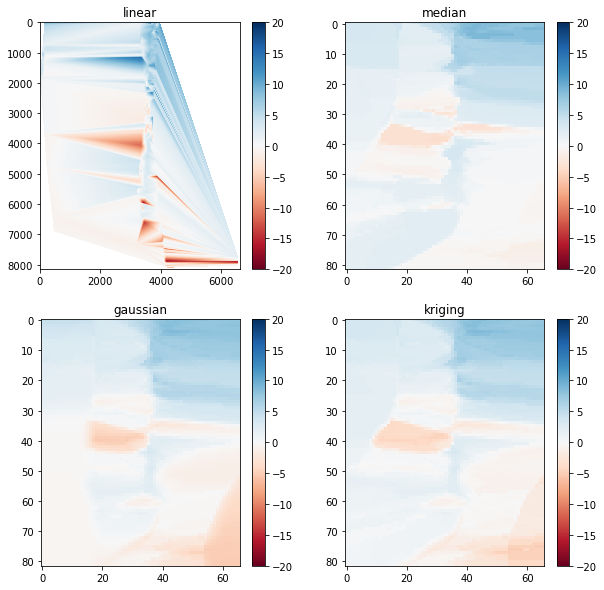

In [16]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(grid_off[0], cmap='RdBu', clim=[-20, 20])
plt.colorbar()
plt.title('linear')
plt.subplot(2,2,2)
plt.imshow(grid_off[1], cmap='RdBu', clim=[-20, 20])
plt.colorbar()
plt.title('median')
plt.subplot(2,2,3)
plt.imshow(grid_off[2], cmap='RdBu', clim=[-20, 20])
plt.colorbar()
plt.title('gaussian')
plt.subplot(2,2,4)
plt.imshow(grid_off[3], cmap='RdBu', clim=[-20, 20])
plt.colorbar()
plt.title('kriging')

Text(0.5, 1.0, 'kriging')

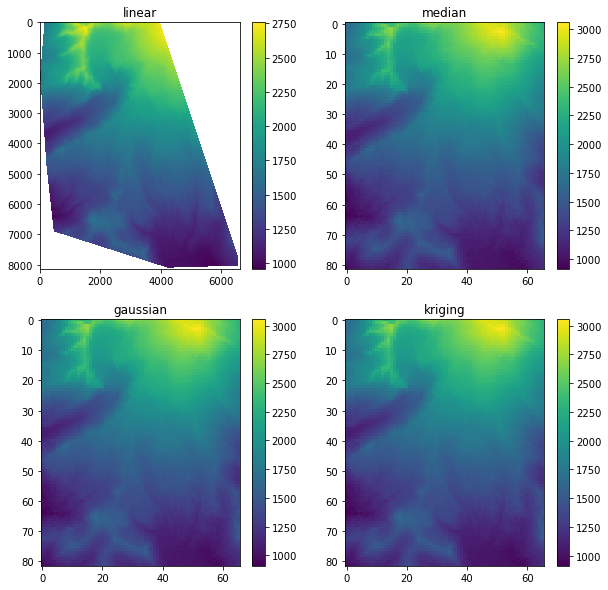

In [17]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
plt.imshow(grid_off[0] + dem.dem, cmap='viridis')
plt.colorbar()
plt.title('linear')
plt.subplot(2,2,2)
plt.imshow(grid_off[1] + dem.dem[::100, ::100], cmap='viridis')
plt.colorbar()
plt.title('median')
plt.subplot(2,2,3)
plt.imshow(grid_off[2] + dem.dem[::100, ::100], cmap='viridis')
plt.colorbar()
plt.title('gaussian')
plt.subplot(2,2,4)
plt.imshow(grid_off[3] + dem.dem[::100, ::100], cmap='viridis')
plt.colorbar()
plt.title('kriging')

8. plot profiles

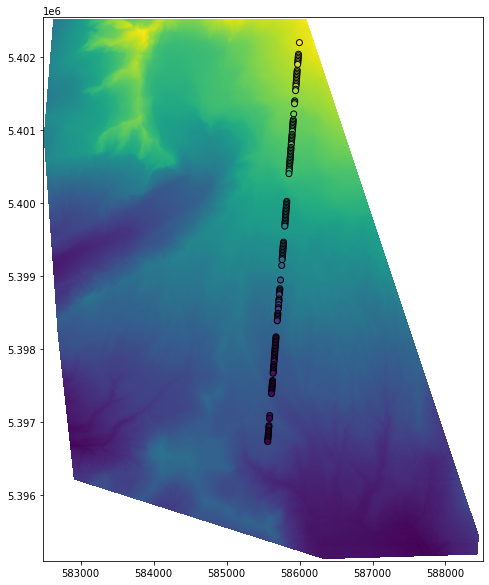

In [18]:
dem_extent = [dem.x.min(), dem.x.max(), dem.y.min(), dem.y.max()]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(grid_off[0] + dem.dem, cmap='viridis', extent=dem_extent)

ddf_gpd[60:220].plot(ax=ax, column='h_li', edgecolor='black')

In [19]:
sample_x = np.linspace(float(ddf_gpd[60:61]['x']), float(ddf_gpd[220:221]['x']), 300)
sample_y = np.linspace(float(ddf_gpd[60:61]['y']), float(ddf_gpd[220:221]['y']), 300)
tot_dist = np.sqrt((sample_x.max() - sample_x.min()) ** 2 + (sample_y.max() - sample_y.min()) ** 2)
sample_dist = np.linspace(0, tot_dist, 300)
xy_pts = gpd.GeoDataFrame({'x': sample_x, 'y': sample_y, 'dist': sample_dist}, geometry=gpd.points_from_xy(sample_x, sample_y), crs='EPSG:32610')

dem_profile = dem.Sample(xy_pts)

is2_surface = grid_off[0] + dem.dem


In [20]:
is2dem_path = '/srv/shared/data-whyjay/is2_BakerDEM.tif'
rasterinfo = {'driver': 'GTiff', 'height': is2_surface.shape[0], 'width': is2_surface.shape[1],
             'count': 1, 'dtype': is2_surface.dtype, 'crs': rio_ds.crs, 'transform': rio_ds.transform}
with rasterio.open(is2dem_path, 'w', **rasterinfo) as is2dem:
    is2dem.write(is2_surface, 1)



In [21]:
dem_is2 = reference_dem(is2dem_path)
dem_is2profile = dem_is2.Sample(xy_pts)

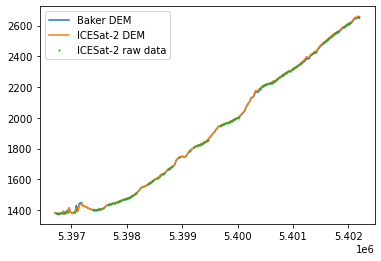

In [22]:
plt.plot(dem_profile['y'], dem_profile['h_dem'], label='Baker DEM')
plt.plot(dem_is2profile['y'], dem_is2profile['h_dem'], label='ICESat-2 DEM')
plt.plot(ddf_gpd['y'][60:220], ddf_gpd['h_li'][60:220], '.', markersize=2, label='ICESat-2 raw data')
# plt.xlim([5397000, 5398000])
plt.legend()

9. ICESat-2 DEM and cross-track profile!

In [29]:
sample_x = np.linspace(584000, 587000, 250)
sample_y = np.linspace(5399000, 5399000, 250)
tot_dist = np.sqrt((sample_x.max() - sample_x.min()) ** 2 + (sample_y.max() - sample_y.min()) ** 2)
sample_dist = np.linspace(0, tot_dist, 250)
xy_pts2 = gpd.GeoDataFrame({'x': sample_x, 'y': sample_y, 'dist': sample_dist}, geometry=gpd.points_from_xy(sample_x, sample_y), crs='EPSG:32610')

dem_profile2 = dem.Sample(xy_pts2)
dem_is2profile2 = dem_is2.Sample(xy_pts2)

glims_path = '/srv/shared/data-whyjay/glims_mtBaker/glims_polygons_EPSG32610.shp'
shapefile = gpd.read_file(glims_path)

idx = atl06lib.points_in_polygon(xy_pts2, glims_path)
xy_pts2['on_ice'] = idx

(5395092.518148141, 5402543.276693823)

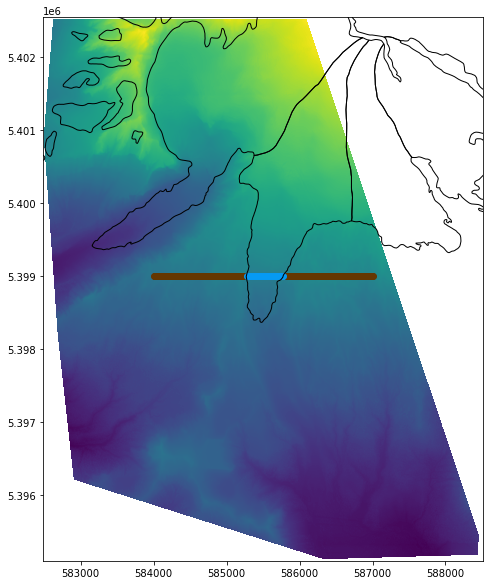

In [30]:
fig, ax = plt.subplots(figsize=(10, 10))
dem_is2.show(ax=ax)
# xy_pts2.plot(ax=ax, edgecolor='black')
xy_pts2[xy_pts2['on_ice'] == False].plot(ax=ax, facecolor='xkcd:brown')
xy_pts2[xy_pts2['on_ice'] == True].plot(ax=ax, facecolor='xkcd:azure')
shapefile.plot(ax=ax, facecolor="none", edgecolor='black')
ax.set_xlim([dem.x.min(), dem.x.max()])
ax.set_ylim([dem.y.min(), dem.y.max()])

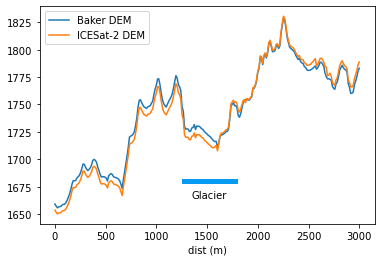

In [35]:
xy_pts2_on_ice = xy_pts2[xy_pts2['on_ice'] == True]

plt.plot(dem_profile2['dist'], dem_profile2['h_dem'], label='Baker DEM')
plt.plot(dem_is2profile2['dist'], dem_is2profile2['h_dem'], label='ICESat-2 DEM')
plt.plot(xy_pts2_on_ice['dist'], xy_pts2_on_ice['dist'] * 0 + 1680, linewidth=5, color='xkcd:azure')
plt.text(1350, 1665, 'Glacier')
plt.xlabel('dist (m)')
plt.legend()